In [8]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
url='http://143.198.233.67/api/v1/waves?buoy=2&start_date=2021-04-19&end_date=2021-04-29&token=rCsdguPf76exUsqLYxuY'
response = requests.get(url).json()
df = pd.DataFrame(response)

In [10]:
df['buoy_id'] = pd.to_numeric(df['buoy_id'])
df['data_id'] = pd.to_numeric(df['data_id'])
df['period'] = pd.to_numeric(df['period'])
df['energy'] = pd.to_numeric(df['energy'])
df['wvdir'] = pd.to_numeric(df['wvdir'])
df['spread'] = pd.to_numeric(df['spread'])
df['mean_average_direction'] = pd.to_numeric(df['mean_average_direction'])
df['spread_direction'] = pd.to_numeric(df['spread_direction'])
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%dT%H:%M:%S.000Z')
df.sort_values('date_time', inplace=True)
total_df = df

In [11]:
total_df['values'] = pd.cut(total_df['period'], [2, 4, 7.5, 12, 18.4])

In [12]:
total_df['wvdir'] = total_df['wvdir'].astype(float)

In [13]:
total_df = total_df.groupby(['date_time', 'values']).agg({'energy': 'sum', 'wvdir': 'mean'}).reset_index()

In [17]:
total_df = total_df.dropna()

In [18]:
total_df['wvdir'] = np.round(total_df['wvdir']).astype('int')
total_df.head()

,date_time,values,energy,wvdir
0,2021-04-19 01:02:17,"(2.0, 4.0]",1.52890,133
1,2021-04-19 01:02:17,"(4.0, 7.5]",18.75520,89
2,2021-04-19 01:02:17,"(7.5, 12.0]",7.05070,155
3,2021-04-19 01:02:17,"(12.0, 18.4]",2.13250,204
4,2021-04-19 02:02:52,"(2.0, 4.0]",1.54578,113


In [19]:
date_time_norm = []
wvdir_norm = []
energy_norm = []
values_norm = []
for index, row in total_df.iterrows():
    wvd  = np.arange(row['wvdir'] - 4.75, row['wvdir'] + 4.75, 0.4)
    ener = norm.pdf(np.arange(-11,11 , 1),0,4.7) * row['energy'] * 80
    ener = np.insert(ener,[0],[0])
    ener = np.append(ener, [0])
    for i in range(len(ener)):
        date_time_norm.append(row['date_time'])
        values_norm.append(row['values'])
        wvdir_norm.append(wvd[i])
        energy_norm.append(ener[i])        

In [20]:
final_df = pd.DataFrame(np.array([date_time_norm, values_norm, wvdir_norm, energy_norm]).T, \
                        columns=['date_time', 'period', 'wvdir', 'energy'])

In [21]:
final_df['energy'] = final_df['energy'].astype(float) * 100
final_df['wvdir'] = final_df['wvdir'].astype(float)

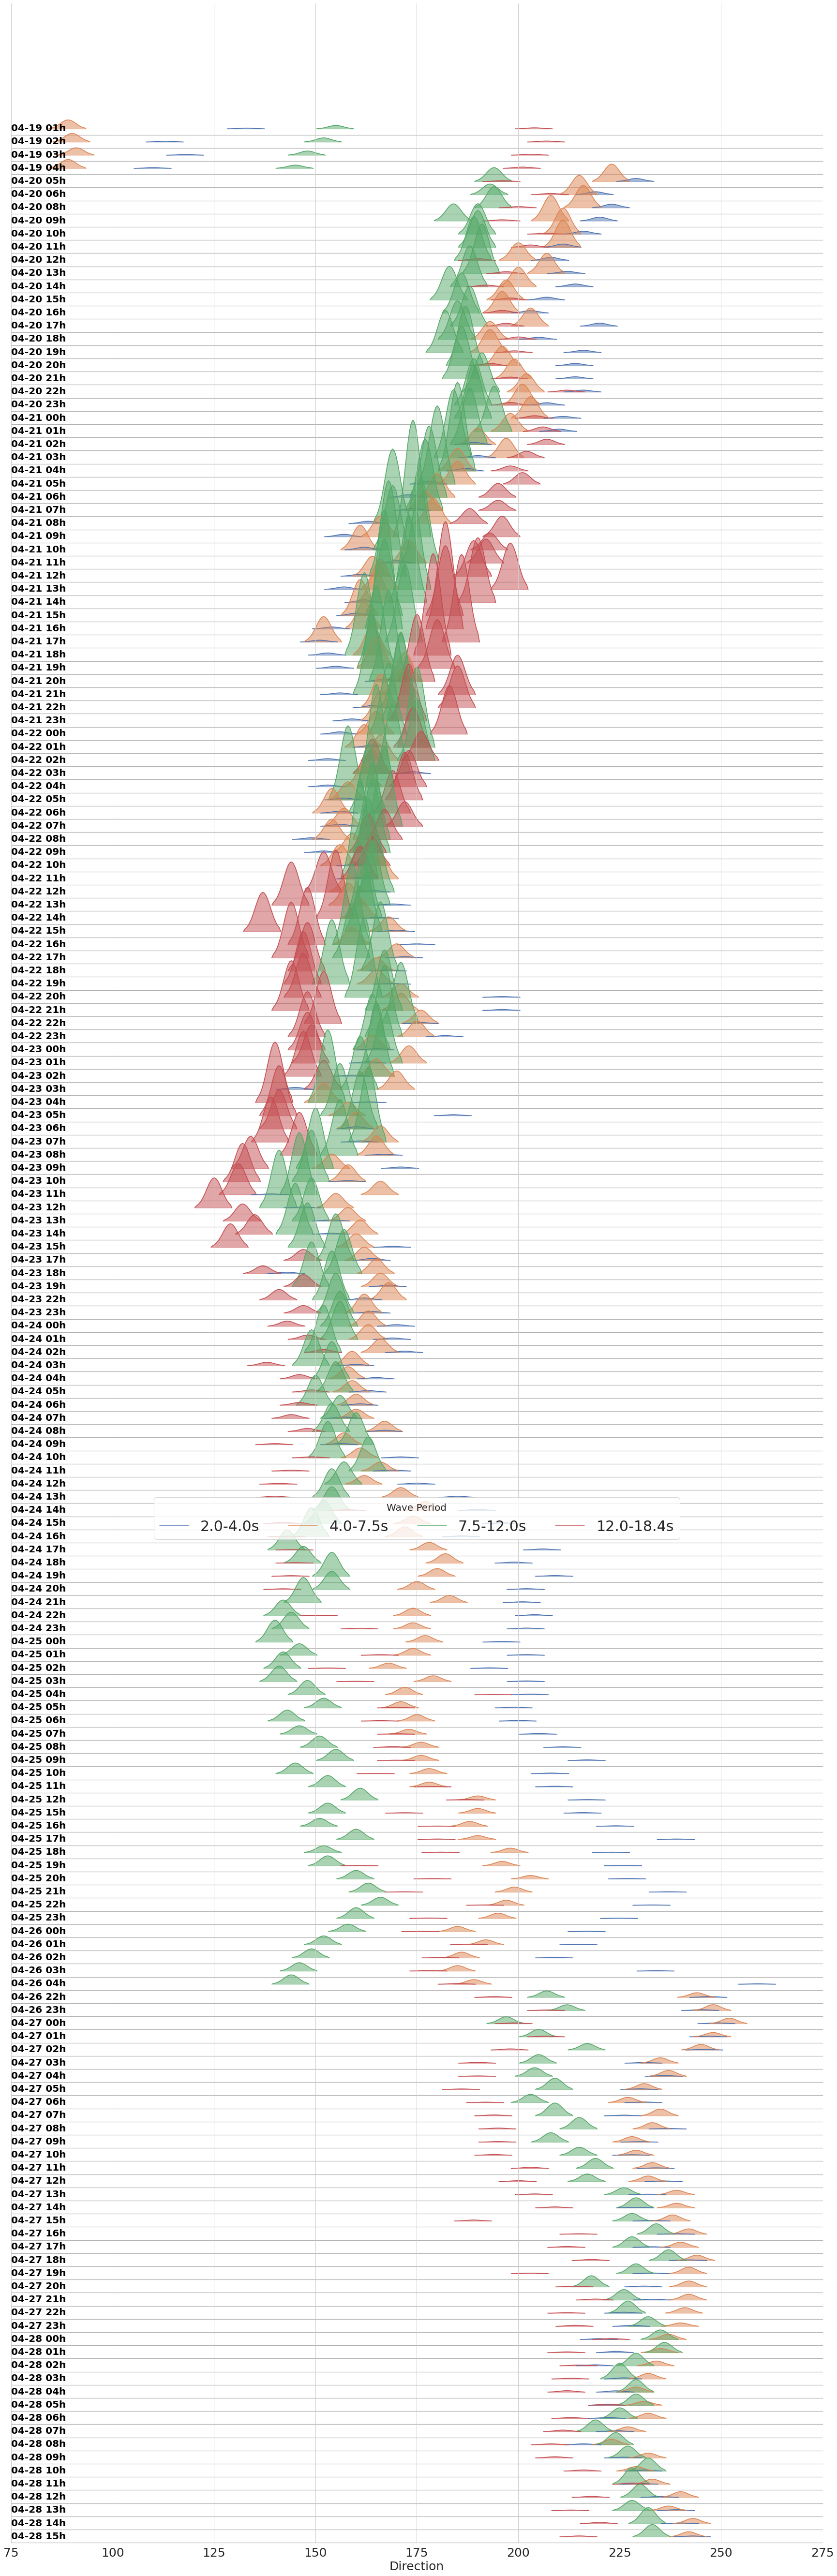

In [22]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

sns.color_palette("cubehelix", as_cmap=True)

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(final_df, row='date_time', hue='period', aspect=60, height=0.4)
# g.map(sns.kdeplot, "value", "name",
#       bw_adjust=5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
g.map(sns.lineplot, 'wvdir', 'energy')
# g.map(sns.kdeplot, "value", "name", clip_on=False, color="w", lw=2, bw_adjust=.5)
#g.map(plt.axhline, y=0, lw=1, clip_on=False, color=None)

# Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)

for ax in g.axes:
    for i in ax[0].lines:
        x1 = i.get_xydata()[:,0]
        y2 = i.get_xydata()[:,1]
        color = i.get_color()
        y1 = y2*0
        ax[0].fill_between(x1, y1=y1, y2=y2, color=color, alpha=0.5)
    ax[0].grid()
    ax[0].spines['right'].set_color('none')
    ax[0].spines['left'].set_color('none')
    ax[0].spines['bottom'].set_color('black')
    ax[0].spines['bottom'].set_alpha(0.3)
    ax[0].set_ylabel('')
    data = ax[0].title.get_text()[17:-16].replace('T', ' ') + "h"
    ax[0].text(0, 0.05, data, fontweight="bold", color=sns.xkcd_rgb['black'],
            ha="left", va="center", transform=ax[0].transAxes, fontsize=20)
    
# g.map(label, label="date_time")
g.set_titles("")
g.set_xlabels("Direction", fontsize=25)

# ticks = ['30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330', '360']
g.set_xticklabels(fontsize=25)
g.set (yticks=[])
# g.set(ylim=(10, max(total_df['name'])), xlim=(min(total_df['value']), max(total_df['value']) - 1))
# g.set(xlim=(0, 359))

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.9)
# plt.legend(loc="lower left", ncol=5)
label = ['2.0-4.0s', '4.0-7.5s', '7.5-12.0s', '12.0-18.4s']
plt.legend(bbox_to_anchor=(0.5, 8), loc=9, ncol=5, facecolor='white', \
           fontsize=30, markerscale=20, labels=label, title='Wave Period', \
          title_fontsize=20)
# Remove axes details that don't play well with overlap
g.savefig('pleds.png')
# plt.savefig("pleds.png")

In [16]:
url='http://143.198.233.67/api/v1/data_buoys?buoy=2&start_date=2021-04-20&end_date=2021-04-24&token=rCsdguPf76exUsqLYxuY'
response = requests.get(url).json()
df = pd.DataFrame(response)
for i in df.columns:
    try:
        df[i] = pd.to_numeric(df[i])
    except:
        pass
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%dT%H:%M:%S.000Z')
df.sort_values('date_time', inplace=True)

In [17]:
columns = ['swvht1', 'swvht2', 'wvdir1', 'wvdir2', 'wspd', 'gust', 'mxwvht1']
for i in columns:
    df.loc[(df[f"flag_{i}"] < 50) & (df[f"flag_{i}"] > 0), i] = np.nan

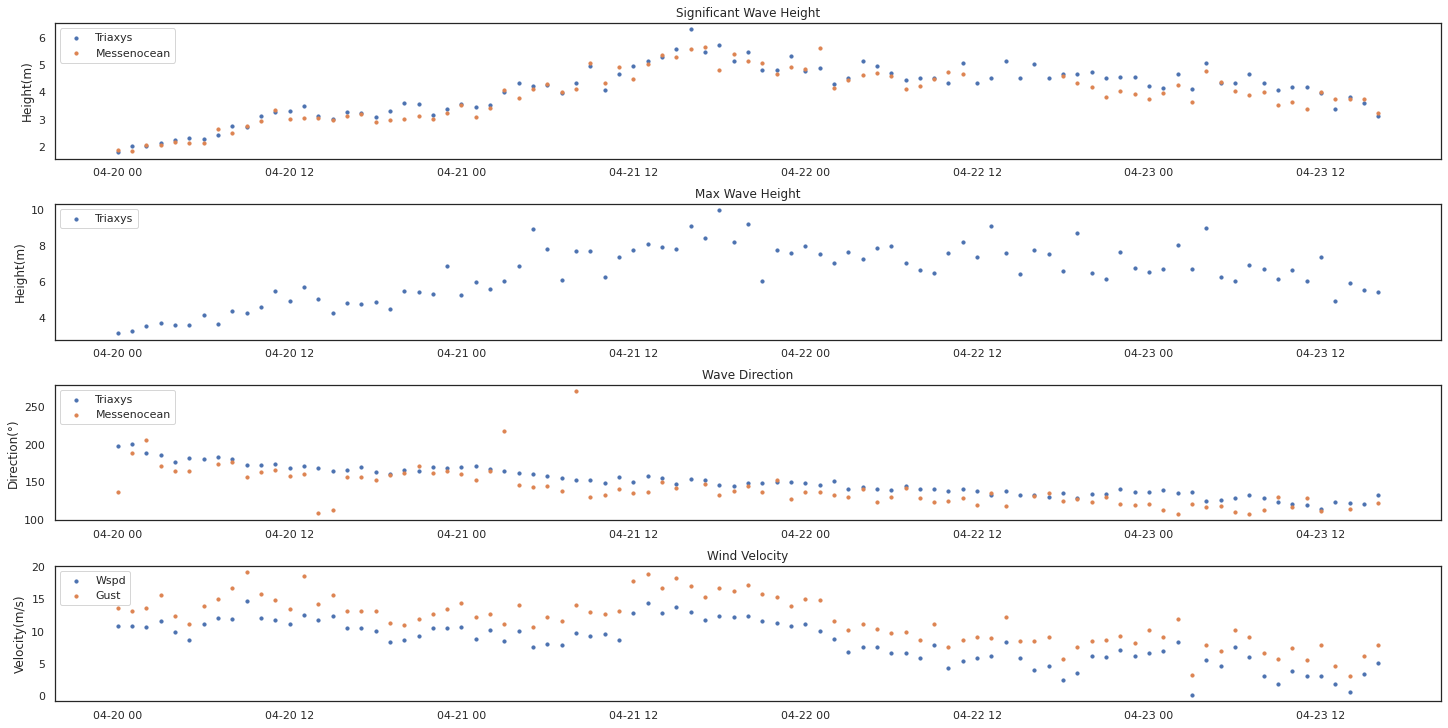

In [18]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(4, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.scatter(df['date_time'],df['swvht1'], s=10)
ax1.scatter(df['date_time'],df['swvht2'], s=10)
ax1.set_title('Significant Wave Height')
ax1.legend(labels=['Triaxys', 'Messenocean'], loc=2, facecolor='white')
ax1.set_ylabel('Height(m)')
ax2 = fig3.add_subplot(gs[1, 0])
ax2.scatter(df['date_time'],df['mxwvht1'], s=10)
ax2.set_title('Max Wave Height')
ax2.set_ylabel('Height(m)')
ax2.legend(labels=['Triaxys'], loc=2, facecolor='white')
ax3 = fig3.add_subplot(gs[2, 0])
ax3.scatter(df['date_time'],df['wvdir1'], s=10)
ax3.scatter(df['date_time'],df['wvdir2'], s=10)
ax3.set_title('Wave Direction')
ax3.set_ylabel('Direction(°)')
ax3.legend(labels=['Triaxys', 'Messenocean'], loc=2, facecolor='white')
ax4 = fig3.add_subplot(gs[3, 0])
ax4.scatter(df['date_time'],df['wspd'], s=10)
ax4.scatter(df['date_time'],df['gust'], s=10)
ax4.set_title('Wind Velocity')
ax4.set_ylabel('Velocity(m/s)')
ax4.legend(labels=['Wspd', 'Gust'], loc=2, facecolor='white')

plt.savefig("wave_wind.png")

In [19]:
url='http://143.198.233.67/api/v1/models?buoy=2&start_date=2021-04-20&end_date=2021-04-23&token=rCsdguPf76exUsqLYxuY'
response = requests.get(url).json()
df_model = pd.DataFrame(response)
for i in df_model.columns:
    try:
        df_model[i] = pd.to_numeric(df_model[i])
    except:
        pass
df_model['date_time'] = pd.to_datetime(df_model['date_time'], format='%Y-%m-%dT%H:%M:%S.000Z')
df_model.sort_values('date_time', inplace=True)

In [20]:
df_model.columns
df_gfs = df_model[df_model['model'] == 'GFS']
df_icon = df_model[df_model['model'] == 'ICON']
df_cosmo = df_model[df_model['model'] == 'COSMO']

In [21]:
df_model.columns

Index(['buoy_id', 'model', 'date_time', 'lat', 'lon', 'swvht', 'wvdir', 'tp',
       'wspd', 'wdir'],
      dtype='object')

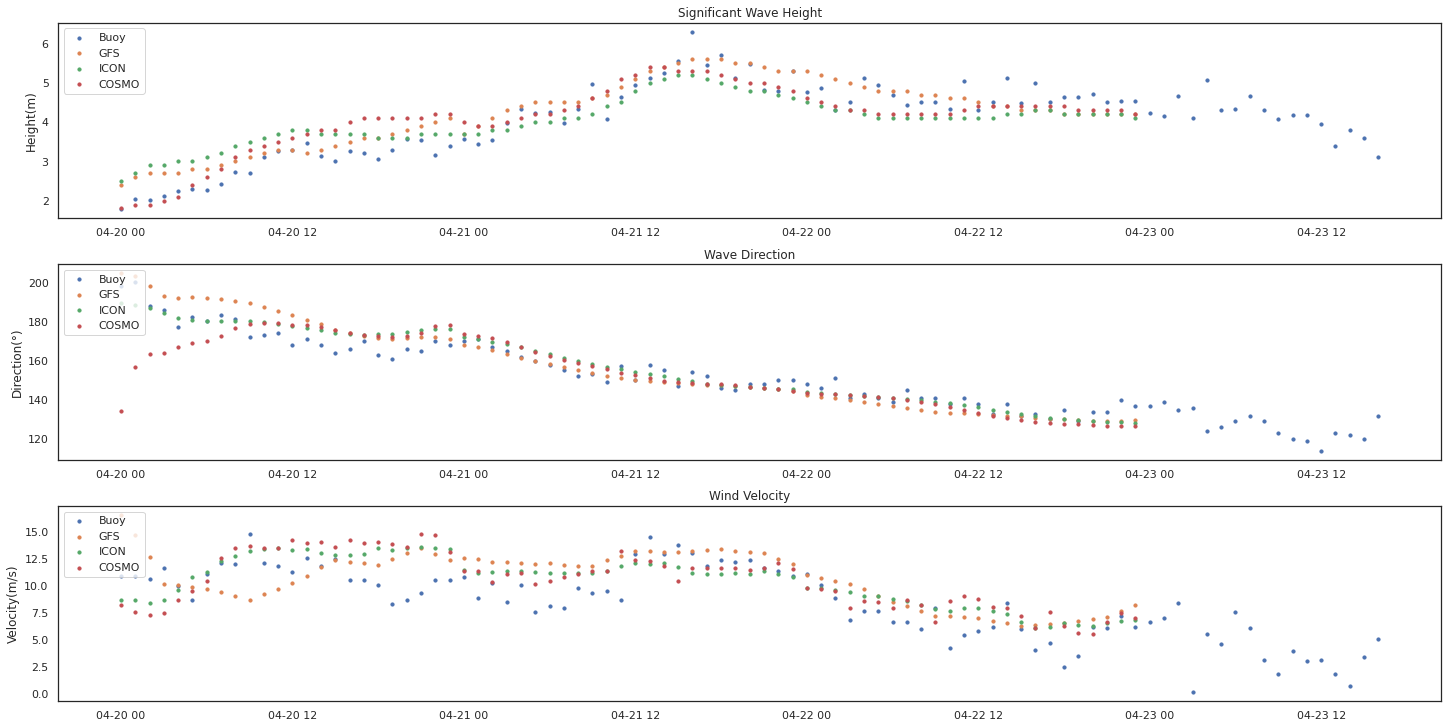

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df['date_time'],df['swvht1'], s=10)
ax1.scatter(df_gfs['date_time'],df_gfs['swvht'], s=10)
ax1.scatter(df_icon['date_time'],df_icon['swvht'], s=10)
ax1.scatter(df_cosmo['date_time'],df_cosmo['swvht'], s=10)
ax1.set_title('Significant Wave Height')
ax1.legend(labels=['Buoy', 'GFS', 'ICON', 'COSMO'], loc=2, facecolor='white')
ax1.set_ylabel('Height(m)')
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(df['date_time'],df['wvdir1'], s=10)
ax3.scatter(df_gfs['date_time'],df_gfs['wvdir'], s=10)
ax3.scatter(df_icon['date_time'],df_icon['wvdir'], s=10)
ax3.scatter(df_cosmo['date_time'],df_cosmo['wvdir'], s=10)
ax3.set_title('Wave Direction')
ax3.set_ylabel('Direction(°)')
ax3.legend(labels=['Buoy', 'GFS', 'ICON', 'COSMO'], loc=2, facecolor='white')
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(df['date_time'],df['wspd'], s=10)
ax4.scatter(df_gfs['date_time'],df_gfs['wspd'] * 0.514444, s=10)
ax4.scatter(df_icon['date_time'],df_icon['wspd'] * 0.514444, s=10)
ax4.scatter(df_cosmo['date_time'],df_cosmo['wspd'] * 0.514444, s=10)
ax4.set_title('Wind Velocity')
ax4.set_ylabel('Velocity(m/s)')
ax4.legend(labels=['Buoy', 'GFS', 'ICON', 'COSMO'], loc=2, facecolor='white')
plt.savefig("wave_wind_model.png")

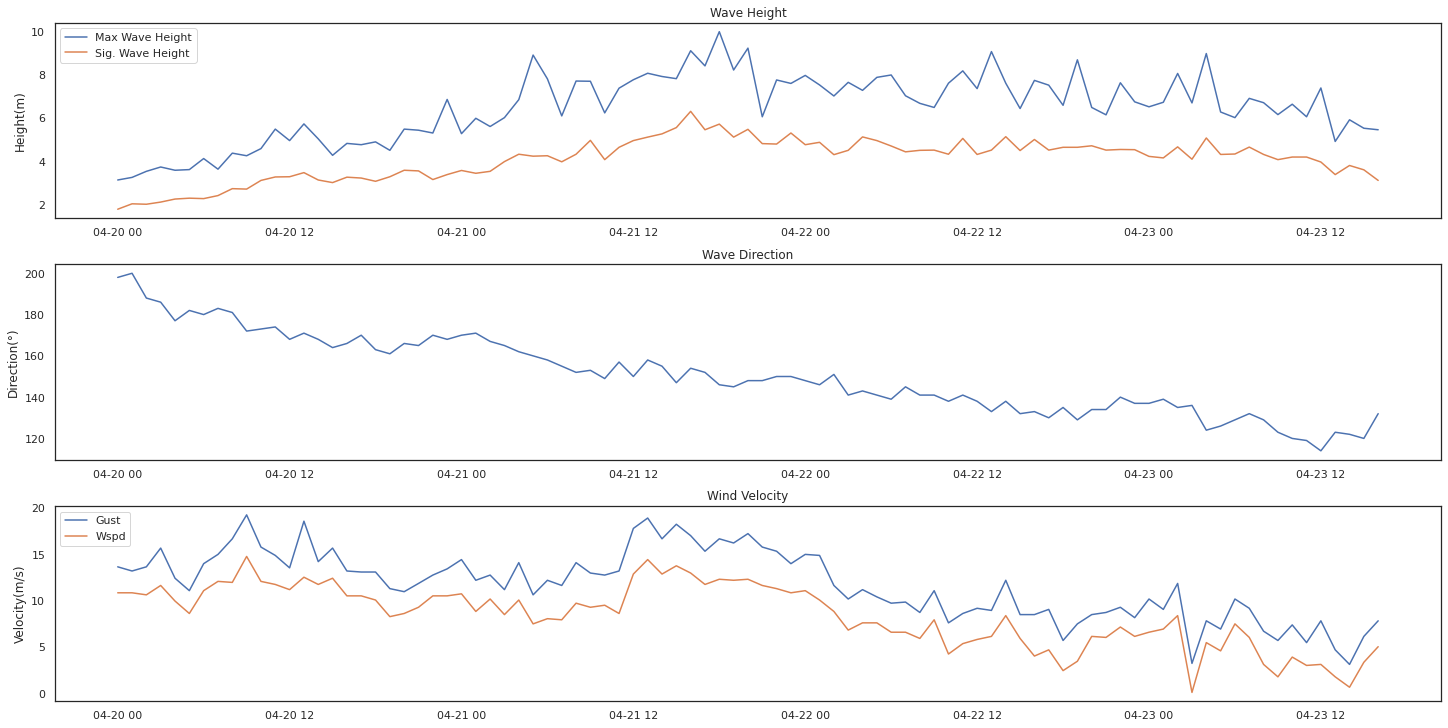

In [23]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(3, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.plot(df['date_time'],df['mxwvht1'])
ax1.plot(df['date_time'],df['swvht1'])
ax1.set_title('Wave Height')
ax1.legend(labels=['Max Wave Height', 'Sig. Wave Height'], loc=2, facecolor='white')
ax1.set_ylabel('Height(m)')
ax3 = fig3.add_subplot(gs[1, 0])
ax3.plot(df['date_time'],df['wvdir1'])
ax3.set_title('Wave Direction')
ax3.set_ylabel('Direction(°)')
ax4 = fig3.add_subplot(gs[2, 0])
ax4.plot(df['date_time'],df['gust'])
ax4.plot(df['date_time'],df['wspd'])
ax4.set_title('Wind Velocity')
ax4.set_ylabel('Velocity(m/s)')
ax4.legend(labels=['Gust', 'Wspd'], loc=2, facecolor='white')
plt.savefig("wave_wind_plot.png")